The purpose of this notebook is to do error analysis of what the model missed in Roxbury.

First, it plots all of the agreement/disagreement between what I could find myself and what the model could find. There is a disappointingly large number of cameras that the model missed.

I then look at each manually-identified camera and print model's results when run on each of the the 6 Street View images. The goal is to see the known camera and look at what score was assigned to the camera. Upon doing this, it seems that many of the known cameras were missed because the cameras were too far away or in bad angles in the images. This implies that more queries to Street View would address this problem.

In [19]:
import folium
import osmnx as ox
import pandas as pd
import os
import pickle
from collections import defaultdict
import cv2
import pylab as pl

import gspread
from oauth2client.service_account import ServiceAccountCredentials
import google_streetview.api

from detectron2.data.datasets import load_coco_json, register_coco_instances
from detectron2.data import MetadataCatalog
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.data import DatasetMapper, transforms, build_detection_train_loader
from detectron2.engine import DefaultTrainer, SimpleTrainer
from detectron2.engine.hooks import PeriodicWriter

# Network of Roxbury

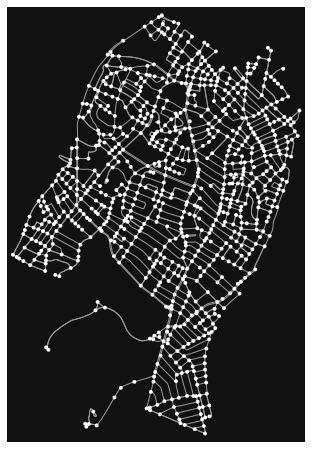

In [3]:
roxbury = ox.graph_from_place('Roxbury, Boston, MA', network_type='drive')

# clean up the intersections and extract their xy coords
roxbury = ox.project_graph(roxbury)
r_intersections = ox.consolidate_intersections(roxbury, tolerance=15, dead_ends=False)
r_intersection_nodes, r_intersection_edges = ox.graph_to_gdfs(r_intersections)
#r_intersection_nodes = r_intersection_nodes[~r_intersection_nodes.lon.isnull()]

fig, ax = ox.plot_graph(r_intersections)

In [4]:
r_nodes, r_edges = ox.graph_to_gdfs(roxbury)

street_counts = []
gps = []
for row in r_nodes.itertuples():
    coords = (row.lat, row.lon)
    gps.append(coords)
    street_counts.append(row.street_count)
    
print(len(gps))
print(gps[0])

1157
(42.319446, -71.100361)


In [14]:
xs, ys = zip(*gps)

minlat = min(xs)
maxlat = max(xs)
minlon = min(ys)
maxlon = max(ys)

# Manually-identified Cameras

In [32]:
manual = pd.read_csv('data/manual_cameras_wboag.tsv', sep='\t')
manual = manual[manual['Region']=='Roxbury']
manual['Dome Camera'] = manual['Dome Camera'].fillna(0)
manual['Button Camera'] = manual['Button Camera'].fillna(0)
manual['Police Box'] = manual['Police Box'].fillna(0)
print(manual.shape)
manual.head()

(59, 9)


,Latitude,Longitude,Name,Dome Camera,Button Camera,Police Box,Notes,Region,URL
2,42.332230,-71.071605,Mass Ave and Gerard,0.0,3.0,1.0,NaN,Roxbury,"https://www.google.com/maps/@42.3322297,-71.07..."
3,42.330624,-71.070058,Mass Ave and Chesterton,0.0,1.0,1.0,NaN,Roxbury,"https://www.google.com/maps/@42.3306241,-71.07..."
4,42.326835,-71.066936,Mass Ave and Newmarket,1.0,0.0,0.0,NaN,Roxbury,"https://www.google.com/maps/@42.3268348,-71.06..."
5,42.321468,-71.072246,Dudley and W Cottage,1.0,0.0,1.0,NaN,Roxbury,"https://www.google.com/maps/@42.3214676,-71.07..."
6,42.319492,-71.070654,Dudley and Folsom,1.0,0.0,1.0,NaN,Roxbury,"https://www.google.com/maps/@42.3194917,-71.07..."


In [34]:
for col in ['Dome Camera', 'Button Camera', 'Police Box']:
    print(col, manual[col].sum())

Dome Camera 63.0
Button Camera 17.0
Police Box 27.0


# Predicted Cameras

In [15]:
pred = pd.read_csv('data/pred_cameras_wboag.tsv', sep='\t')

# Format data
pred['max_prob'] = pred['probs'].apply(lambda t: float(t[1:].split(',')[0]))
pred['confirm dome'] = pred['confirm dome'].fillna(0)
pred['confirm button'] = pred['confirm button'].fillna(0)
pred['confirm box'] = pred['confirm box'].fillna(0)

# Only predictions that are confirmed
pred = pred[(pred['confirm dome'] + pred['confirm button'] + pred['confirm box'])>0]

# Only in the area of Roxbury
pred = pred[(pred.Latitude >=minlat)&(pred.Latitude <=maxlat)&
            (pred.Longitude>=minlon)&(pred.Longitude<=maxlon)]

print(pred.shape)
pred.head(n=5)

(33, 8)


,File,Latitude,Longitude,probs,confirm dome,confirm button,confirm box,max_prob
0,image4029.jpg,42.317876,-71.081978,"[0.9917173981666565, 0.39172911643981934, 0.31...",0.0,1.0,1.0,0.991717
1,image20136.jpg,42.328508,-71.079257,"[0.9908430576324463, 0.39918622374534607, 0.22...",1.0,0.0,1.0,0.990843
3,image34545.jpg,42.305539,-71.067866,"[0.9846373200416565, 0.4426528513431549, 0.433...",1.0,0.0,1.0,0.984637
8,image22944.jpg,42.321355,-71.072195,"[0.979006826877594, 0.7766727805137634, 0.1959...",1.0,0.0,1.0,0.979007
9,image24637.jpg,42.298185,-71.086922,"[0.9780111312866211, 0.24306745827198029, 0.23...",1.0,0.0,1.0,0.978011


# Visualize Roxbury

In [16]:
def euclidian(a, b):
    c2 = (a[0]-b[0])**2 + (a[1]-b[1])**2
    return c2 ** 0.5

In [17]:
pred_coords = set()
for i,row in enumerate(pred.itertuples()):
    coord = (row.Latitude, row.Longitude)
    pred_coords.add(coord)
    
manual_coords = set()
for i,row in enumerate(manual.itertuples()):
    coord = (row.Latitude, row.Longitude)
    manual_coords.add(coord)

In [35]:
# Create a map
b_folium = folium.Map(location=[42.321207,-71.077061], tiles='openstreetmap', zoom_start=14)


# Manually Identified
for i,row in enumerate(manual.itertuples()):
    coord = (row.Latitude, row.Longitude)

    # Check if predicted manual (ie very very close)
    pred_match = False
    for c in pred_coords:
        if euclidian(coord, c) < .0003:
            pred_match = True
            
    if pred_match:
        # Will be printed below
        continue
    else:
        icon = folium.map.Icon(color='blue')
        folium.Marker(coord, popup=f'{coord}', tooltip=str(coord), icon=icon).add_to(b_folium)
    
    

for i,row in enumerate(pred.itertuples()):
    coord = (row.Latitude, row.Longitude)
    
    # Check if matches manual (ie very very close)
    manual_match = False
    for c in manual_coords:
        if euclidian(coord, c) < .0003:
            manual_match = True

    if manual_match:
        color = 'purple'
    else:
        color = 'red'

    # plot the TP or FP
    icon = folium.map.Icon(color=color)
    folium.Marker(coord, popup=f'{coord}', tooltip=str(coord), icon=icon).add_to(b_folium)

    
b_folium  

# Load Model

In [20]:
# Custom Trainer class to include custom data augmentations
class Trainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        # Set up data augmentation
        augs = [transforms.ResizeShortestEdge(
                    [640, 672, 704, 736, 768, 800],
                     max_size=1333, sample_style="choice"),
                transforms.RandomBrightness(0.8, 1.2),
                transforms.RandomSaturation(0.8, 1.2),
                transforms.RandomFlip(prob=0.5)]
        data_loader = build_detection_train_loader(cfg,
            mapper=DatasetMapper(cfg, is_train=True, 
                                 augmentations=augs))
        return data_loader

In [21]:
def build_test_dict(datadir, image_dir, ann_file):
    # Test dataset
    name = ann_file.split('.')[0]
    test_dataset_name = f"test_{name}_data"
    test_data_dir = os.path.join(datadir, image_dir)
    test_json_file = os.path.join(datadir, image_dir, ann_file)
    print(test_json_file)

    register_coco_instances(test_dataset_name, {}, test_json_file, test_data_dir)
    test_dict = load_coco_json(test_json_file, test_data_dir,
                    dataset_name=test_dataset_name)
    test_metadata = MetadataCatalog.get(test_dataset_name)
    
    return test_dict, test_metadata


In [22]:
def load_model(datadir,  training_dict, training_metadata, output_dir):
    
    # Most importantly, let's set up a model type
    model_type = "retinanet"
    model_file = "COCO-Detection/retinanet_R_50_FPN_3x.yaml"

    # Create a configuration and set up the model and datasets
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(model_file))
    cfg.DATASETS.TRAIN = (training_metadata.name,)
    #cfg.DATASETS.TEST = (test_metadata.name,)
    cfg.OUTPUT_DIR = f"{output_dir}/{model_type}_training_output"
    cfg.DATALOADER.NUM_WORKERS = 4
    if model_type == "maskrcnn":
        cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(training_metadata.thing_classes)
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05
    if model_type == "retinanet":
        cfg.MODEL.RETINANET.NUM_CLASSES = len(training_metadata.thing_classes)
        cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.05
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_file)  # Initialize weights from Model Zoo
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # (default: 512)

    # Solver options
    cfg.SOLVER.BASE_LR = 1e-3           # Base learning rate
    cfg.SOLVER.GAMMA = 0.5              # Learning rate decay
    cfg.SOLVER.STEPS = (250, 500, 750)  # Iterations at which to decay learning rate
    cfg.SOLVER.MAX_ITER = 1000          # Maximum number of iterations
    cfg.SOLVER.WARMUP_ITERS = 100       # Warmup iterations to linearly ramp learning rate from zero
    cfg.SOLVER.IMS_PER_BATCH = 1        # Lower to reduce memory usage (1 is the lowest)

    # Set low threshold (for high recall)
    cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.05

    ######################
    # Train Model

    # Create an output folder and delete any old files
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    for fname in os.listdir(cfg.OUTPUT_DIR):
        if "tfevents" in fname:
            os.remove(os.path.join(cfg.OUTPUT_DIR, fname))

    # Create a Trainer using the data augmentations defined above and train the network
    # To avoid creating a custom trainer class, you can use 
    #  `trainer = SimpleTrainer(cfg)` : A no-frills training pipeline with nothing added  
    #  `trainer = DefaultTrainer(cfg)` : The default training pipeline with some data augmentation and hooks
    trainer = Trainer(cfg)

    # Hack to reduce the printing frequency, which defaults to every 20 iterations..
    # There is a cleaner way to do this using `trainer.build_hooks()` but it requires much more effort.
    for hook in trainer._hooks:
        if isinstance(hook, PeriodicWriter):
            hook._period = 50

    # Finally, train the network
    trainer.resume_or_load(resume=True)


    ######################
    # Evaluate model

    # Load weights from the most recent training run
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

    # Run the official Detectron2 test evaluator, which returns useful metrics
    #if model_type == "maskrcnn":
    #    eval_tasks = ("segm",)
    #elif model_type == "retinanet":
    #    eval_tasks = ("bbox",)
    #evaluator = COCOEvaluator(test_metadata.name,
    #                          tasks=eval_tasks,
    #                          distributed=False,
    #                          output_dir=f"output/detector2/walkthrough/{model_type}_test_output")
    #trainer.test(cfg, trainer.model, evaluators=evaluator)

    return cfg

In [ ]:
datadir = '/crimea/wboag/2021/aclum/camera-detection/data/all_known'
train_dict, train_metadata = build_test_dict(datadir, 'non-bh', 'non-bh.json')
cfg = load_model(datadir, train_dict, train_metadata, 'output/detector2/nonresidential-1')

In [25]:
predictor = DefaultPredictor(cfg)

# Predict Cameras in Roxbury

In [26]:
with open('gsv/metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)
    
    
gps_to_images = defaultdict(list)
for image_id,m in metadata.items():
    # Only looking at the images from the large run, which (for me) have image_id > 1200
    if image_id <= 1200: continue
    
    gps = tuple(map(float,m['location'].split(',')))
    gps_to_images[gps].append(image_id)

gps_to_images = dict(gps_to_images)

In [27]:
def euclidian(a, b):
    c2 = (a[0]-b[0])**2 + (a[1]-b[1])**2
    return c2 ** 0.5

In [28]:
def viz_image_by_id(image_id):
    path = f'/crimea/wboag/2021/aclum/streets/gsv/image{image_id:04d}.jpg'
    print(path)
    img = cv2.imread(path)
    
    ################
    # Show Image
    pl.figure(figsize=(34,18))
    pl.imshow(img[:, :, ::-1])
            
        
    ################
    # Predicted Boxes
    instances = predictor(img)['instances']
    probs   = instances.scores 
    boxes   = instances.pred_boxes 
    classes = instances.pred_classes

    #colors = ['r', 'deepskyblue', 'b', 'g', 'c', 'm', 'y', 'tab:orange', 'tab:pink', 'goldenrod']
    colors = ['red', 'yellow']
    counter = 0
    for j,box in sorted(enumerate(boxes), key=lambda t:probs[t[0]], reverse=True):
        # Only show the 7 highest-probability boxes
        counter += 1
        if counter > 7: break

        #color = 'r' # colors[j]
        #box = boxes[j]
        pred_label = classes[j]
        color = colors[pred_label]
        prob = probs[j]

        # Plot rectangle
        x1,y1,x2,y2 = box.tolist()
        rectangle = pl.Rectangle((x1,y1), x2-x1, y2-y1, ec=color, facecolor='None', lw=1+10*prob)
        pl.gca().add_patch(rectangle)

        # Plot probability
        pl.text(x1, y1*.99, f'{int(prob*100)}%', c=color, fontsize=6+50*prob)
        
        
    pl.show()

In [ ]:
# Manually Identified
for i,row in enumerate(manual.itertuples()):
    coord = (row.Latitude, row.Longitude)

    # Check if predicted manual (ie very very close)
    #pred_match = False
    #for c in pred_coords:
    #    if euclidian(coord, c) < .0003:
    #        pred_match = True            
    #if pred_match:
    #    continue

    # find the closest non-camera
    mindist = 1.0
    for c,ids in gps_to_images.items():
        d = euclidian(coord, c)
        if d < mindist:
            mindist = d
            closest = ids
            
    #print(closest)
    #continue

    print(i)
    print(row.URL)
    for image_id in closest:
        #if image_id <= 1400: continue
        viz_image_by_id(image_id)
    
    print('='*80)
    print('\n')
    
    #break
